# Prospector Output Tutorial

In this tutorial, we'll go over working with the Prospector h5 files to get the stellar population properties we want and model SED. If you have more Prospector needs/questions, etc., please see: https://prospect.readthedocs.io/en/latest/.

You can download the h5 files on BRIGHT by selecting the GRB's you want the data for on the main page and hitting the "Download only Samples" button. You can also do this on the individual pages by selecting the "Download Nested Sampling Samples" button at the top of the page across from the thumbnail.

In [1]:
# Load in all the imports
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
import pandas as pd
from prospect.models.transforms import tage_from_tuniv


import fsps
import sedpy
import prospect
import numpy as np
from prospect.models import priors
from prospect.models.sedmodel import SedModel
import time
import scipy
import h5py
from scipy.special import gamma, gammainc
from prospect.utils.obsutils import fix_obs

import os
from prospect.utils.obsutils import fix_obs
from scipy.stats import truncnorm
from scipy.signal import savgol_filter

from prospect.models.templates import TemplateLibrary
from prospect.io.read_results import results_from, get_sps
from prospect.models.sedmodel import PolySedModel
from prospect.utils.plotting import quantile

from prospect.sources import CSPSpecBasis
from sedpy.observate import load_filters
from prospect.plotting.utils import sample_posterior
from astropy.cosmology import WMAP9


from prospect.models import priors, SedModel
from prospect.models.sedmodel import PolySedModel
from prospect.models.templates import TemplateLibrary
from prospect.sources import CSPSpecBasis
from sedpy.observate import load_filters
from prospect.utils.obsutils import fix_obs
from scipy.stats import truncnorm
from prospect.models.transforms import tage_from_tuniv
from prospect.models.sedmodel import PolySpecModel
from prospect.models.sedmodel import SpecModel

import corner as triangle
from prospect.io.read_results import traceplot, subcorner

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.linewidth'] = 2.

# Load in h5 file

In [2]:
run_param = {}
file = '050509B_mcmc.h5'

res, obs, _ = results_from(file, dangerous=False)

# What values do we want?

The main Prospector output give total mass formed, age at the time of observation, dust attenuation of old and young stellar populations in units of optical depth, stellar metallicity (also gas-phase metallicity for spectroscopic fits), and redshift. Some of these values we don't want to change, but others we do - for example, we prefer to have stellar mass rather than mass formed, and the mass-weighted age in place of the age of observation, and total dust attenuation in magnitudes. We would also like to get the star formation rate (SFR) and specific star-formation rate. Please see Prospector documentation and Nugent et al. 2022 for more information and the equations for each of these conversions!


Here, we'll show you how to get the posterior distributions for each property, make a corner plot and an SED for the data. You can always just download the model photometry and spectroscopy we produced from our Prospector fits (which is based on the median of the posterior distributions), but you can also build a bunch of models based on different stellar population properties and see how that changes the SED!

## Corner plot and Stellar Population Property Conversions

In [3]:
# Draw random values from the mass posterior distributions in the h5 files - do about 50 different cdfs and then take
# the median and 50% cdf


# To convert from tage to mass-weighted age
def age(tage, tau):
    """
    Function to convert from tage and tau to mass-weighted age
    Note that mass-weighted age = tage - age(tage, tau)
    This only works for a delayed-tau SFH
    """
    age = 2*tau - tage**2/(tau*np.exp(tage/tau)-tau-tage)
    return age

# This is the parameter we use for age when we are also determining a photometric redshift
# The "tmax" parameter is essentually a fraction of the age of the universe at that redshift
def tmax_to_tage(tmax=None,redshift=None,**kwargs):
    return WMAP9.age(redshift).value*(tmax) # in Gyr

# The star formation rate
def SFR(tage, tau, mass):
    """
    To determine SFR from delayed-tau SFH
    Takes in lists of tage, tau and mass
    Outputs SFR in M_sol/yr
    """
    psi_arr = []
    
    for i in np.arange(0, len(tage), 1):
        # for delay tau this function gives the (unnormalized) SFR 
        # for any t, tau combo in M_sun/Gyr
        tau_i = tau[i]
        sfr = lambda t,tau_i: (t) * np.exp(-t/tau_i)
        # now we numerically integrate this SFH from 0 to tage to get the mass formed
        times = np.linspace(0, tage[i], 1000)
        A = np.trapz(sfr(times, tau[i]), times)
        # and now we renormalize the formed mass to the actual mass value 
        # to get the the SFR in M_sun per Gyr 
        psi = mass[i] * sfr(tage[i], tau[i]) / A
        # if we want SFR in Msun/year
        psi /= 1e9
        psi_arr.append(psi)
    return np.array(psi_arr)

# Mass formed to stellar mass
def sm(t_m, logMF):
    """
    t_m = mass-weighted age
    logMF = logged mass formed value
    """
    logtm = np.log10(t_m * 1e9)
    MF = 10**logMF
    logsm = 1.06 - 0.24 * logtm + 0.01*(logtm**2)
    
    sm = 10**logsm
    mass = sm * MF
    return np.log10(mass)


def specific_SFR(mass, z, sfr):
    # First solve for sSFR using full post. dist of mass and SFR
    # Take the mode
    sSFR = np.log10(np.array(sfr)/(10**np.array(mass)))
    # Find lookback time    
    type_SF = []
    # If z was fixed in the fit, t_lookback is a single value
    if type(z) == float:
        t_lookback = tage_from_tuniv(zred=z, tage_tuniv=1.0)*1e9

        for s in sSFR:
            sf_cond = np.log10(1/3/(t_lookback))
            q_cond = np.log10(1/20/(t_lookback))
            
            if s >= sf_cond:
                type_SF.append('SF')
            elif (s < sf_cond) & (s > q_cond):
                type_SF.append('T')
            else: 
                type_SF.append('Q')          
    
    else:
        for i in np.arange(0, len(z), 1):
            t_lookback = tage_from_tuniv(zred=z[i], tage_tuniv=1.0)*1e9
            
            sf_cond = np.log10(1/3/(t_lookback))
            q_cond = np.log10(1/20/(t_lookback))
            
            if sSFR[i] >= sf_cond:
                type_SF.append('SF')
            elif (sSFR[i] < sf_cond) & (sSFR[i] > q_cond):
                type_SF.append('T')
            else: 
                type_SF.append('Q')   
    
    SF_mode = scipy.stats.mode(type_SF)[0][0]
    
    return SF_mode, sSFR

def theta_posteriors(results, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    # Change from optical depth to dust: note must have dust2 as free parameter for this to work
    
    # Get all model parameter names (free or fixed parameters)
    full_mod = []
    for i in np.arange(0, len(results['model_params']),1):
        full_mod.append(results['model_params'][i]['name'])
    
    # If we looked at the combination of young (dust1) and old (dust2) stellar populations
    if 'dust1' in full_mod:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    # We don't use dust1 for known quiescent galaxies
    elif 'dust1' not in full_mod:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086

    # Define some variables   
    tau = theta_samp[:, parnames.tolist().index('tau')]
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]


    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]
    
    # If redshift was a sampled parameter
    if 'zred' in parnames:
        zred = theta_samp[:, parnames.tolist().index('zred')]

        tmax_par = theta_samp[:, parnames.tolist().index('tmax')]
        t_age = tmax_to_tage(tmax=tmax_par,redshift=zred)
        tau = theta_samp[:, parnames.tolist().index('tau')]
        
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 

        stell_mass = sm(t_m, mass_log)   
        
        type_SF, spSFR = specific_SFR(mass=stell_mass, z=zred, sfr=SFR_calc)
        type_z = 'photo-z'
        
    # If we knew the redshift
    elif 'zred' not in parnames:
        t_age_par = theta_samp[:, parnames.tolist().index('tage')]
        t_age = t_age_par.copy()
        
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 

        stell_mass = sm(t_m, mass_log)
        
        for i in np.arange(0, len(res['model_params']),1):
            if res['model_params'][i]['name'] == 'zred':
                if res['model_params'][i]['isfree'] == False:
                    zred = res['model_params'][i]['init'] 
                    type_z = 'spec-z'
        type_SF, spSFR = specific_SFR(mass=stell_mass, z=zred, sfr=SFR_calc)

    return dust2, t_m, SFR_calc, stell_mass, logzsol, zred, spSFR, type_z, type_SF


# To get all this data in a corner plot
def corner_plot(dust2, t_m, SFR_calc, stell_mass, logzsol, zred, **kwargs):    
    
    check_zred = isinstance(zred, float)
    
    # If redshift was sampled in Prospector fit
    if check_zred == False: 
        new_theta = []
        for i in np.arange(0, len(stell_mass), 1):
            new_idx = [zred[i], dust2[i], t_m[i], SFR_calc[i], stell_mass[i], logzsol[i]]
            new_theta.append(new_idx)
            
        new_theta = np.array(new_theta)

        lbls = ['z', 'A$_V$', '$t_m$ [Gyr]', 'log(SFR)', 'log(M/M$_\odot$)', 'log(Z/Z$_\odot$)']
    
    # If redshift was known
    else:
        new_theta = []
        for i in np.arange(0, len(stell_mass), 1):
            new_idx = [dust2[i], t_m[i], SFR_calc[i], stell_mass[i], logzsol[i]]
            new_theta.append(new_idx)


        new_theta = np.array(new_theta)

        lbls = ['A$_V$', '$t_m$ [Gyr]', 'log(SFR)', 'log(M/M$_\odot$)', 'log(Z/Z$_\odot$)']

    cornerfig = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = lbls,
                             color = 'darkcyan', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, 
                             title_kwargs={"fontsize": 15, 'x': 0.6, 'y':1.05}, label_kwargs={"fontsize": 15}, 
                             label_fmt = ' .2f')
    return cornerfig

## SED Code

We first have a generic model call that we have used for all our short GRBs. In the "load_model" function, change 
add_duste=True if an IR dust emission model was used (we do not do this as we do not have well-sampled IR for many hosts), opt_spec=True if a spectrum was used, smooth_spec = True for spectral smoothing (was not used), add_dust1 = True if you have a young stellar population (not used for quiescent hosts), massmet = True for the mass-metallicity model (alwats use), add_agn = True if there is an AGN in the host (thus far, only for GRB 150101B), and add_neb=True for nebular emission model (always use). Use the jit=True and mixture_model=True for hosts with high S/N spectrum (described in Nugent et al. 2022)

The kernel might break if the model is not correct!


Please copy the below into a file named 'gallazzi_05_massmet.txt' for the Gallazzi Mass-Metallicity relation

In [4]:
"""
# mass P50 P16 P84
# corrected to Chabrier IMF
8.87 -0.60 -1.11 -0.00
9.07 -0.61 -1.07 -0.00
9.27 -0.65 -1.10 -0.05
9.47 -0.61 -1.03 -0.01
9.68 -0.52 -0.97 0.05
9.87 -0.41 -0.90 0.09
10.07 -0.23 -0.80 0.14
10.27 -0.11 -0.65 0.17
10.47 -0.01 -0.41 0.20
10.68 0.04 -0.24 0.22
10.87 0.07 -0.14 0.24
11.07 0.10 -0.09 0.25
11.27 0.12 -0.06 0.26
11.47 0.13 -0.04 0.28
11.68 0.14 -0.03 0.29
11.87 0.15 -0.03 0.30
"""

'\n# mass P50 P16 P84\n# corrected to Chabrier IMF\n8.87 -0.60 -1.11 -0.00\n9.07 -0.61 -1.07 -0.00\n9.27 -0.65 -1.10 -0.05\n9.47 -0.61 -1.03 -0.01\n9.68 -0.52 -0.97 0.05\n9.87 -0.41 -0.90 0.09\n10.07 -0.23 -0.80 0.14\n10.27 -0.11 -0.65 0.17\n10.47 -0.01 -0.41 0.20\n10.68 0.04 -0.24 0.22\n10.87 0.07 -0.14 0.24\n11.07 0.10 -0.09 0.25\n11.27 0.12 -0.06 0.26\n11.47 0.13 -0.04 0.28\n11.68 0.14 -0.03 0.29\n11.87 0.15 -0.03 0.30\n'

In [5]:
class MassMet(priors.Prior):
    """A Gaussian prior designed to approximate the Gallazzi et al. 2005 
    stellar mass--stellar metallicity relationship.
    """

    prior_params = ['mass_mini', 'mass_maxi', 'z_mini', 'z_maxi']
    distribution = truncnorm
    massmet = np.loadtxt('gallazzi_05_massmet.txt')
    def __len__(self):
        
        """ Hack to work with Prospector 0.3
        """
        return 2

    def scale(self,mass):
        upper_84 = np.interp(mass, self.massmet[:,0], self.massmet[:,3]) 
        lower_16 = np.interp(mass, self.massmet[:,0], self.massmet[:,2])

        return (upper_84-lower_16)

    def loc(self,mass):
        return np.interp(mass, self.massmet[:,0], self.massmet[:,1])

    def get_args(self,mass):
        a = (self.params['z_mini'] - self.loc(mass)) / self.scale(mass)
        b = (self.params['z_maxi'] - self.loc(mass)) / self.scale(mass)

        return [a, b]

    @property

    def range(self):
        return ((self.params['mass_mini'], self.params['mass_maxi']),\

                (self.params['z_mini'], self.params['z_maxi']))

    def bounds(self, **kwargs):
        if len(kwargs) > 0:

            self.update(**kwargs)

        return self.range

    def __call__(self, x, **kwargs):

        """Compute the value of the probability density function at x and
        return the ln of that.
        :params x:
           x[0] = mass, x[1] = metallicity. Used to calculate the prior

        :param kwargs: optional
            All extra keyword arguments are used to update the `prior_params`.


        :returns lnp:

            The natural log of the prior probability at x, scalar or ndarray of
            same length as the prior object.

        """

        if len(kwargs) > 0:
            self.update(**kwargs)

        p = np.atleast_2d(np.zeros_like(x))
        a, b = self.get_args(x[...,0])
        p[...,1] = self.distribution.pdf(x[...,1], a, b, loc=self.loc(x[...,0]), scale=self.scale(x[...,0]))
        with np.errstate(invalid='ignore'):
            p[...,1] = np.log(p[...,1])

        return p

    def sample(self, nsample=None, **kwargs):
        """Draw a sample from the prior distribution.
        :param nsample: (optional)
            Unused
        """
        if len(kwargs) > 0:
            self.update(**kwargs)
        mass = np.random.uniform(low=self.params['mass_mini'],high=self.params['mass_maxi'],size=nsample)
        a, b = self.get_args(mass)
        met = self.distribution.rvs(a, b, loc=self.loc(mass), scale=self.scale(mass), size=nsample)
        return np.array([mass, met])

    def unit_transform(self, x, **kwargs):
        """Go from a value of the CDF (between 0 and 1) to the corresponding
        parameter value.
        :param x:
            A scalar or vector of same length as the Prior with values between
            zero and one corresponding to the value of the CDF.
        :returns theta:
            The parameter value corresponding to the value of the CDF given by
            `x`.
        """

        if len(kwargs) > 0:
            self.update(**kwargs)
        mass = x[0]*(self.params['mass_maxi'] - self.params['mass_mini']) + self.params['mass_mini']
        a, b = self.get_args(mass)
        met = self.distribution.ppf(x[1], a, b, loc=self.loc(mass), scale=self.scale(mass))
        return np.array([mass,met])
    

def dust2_to_dust1(dust2=None, **kwargs):
    return dust2
def massmet_to_mass(massmet=None, **extras):
    return 10**massmet[0]
def massmet_to_logzol(massmet=None,**extras):
    return massmet[1]
def gas_logz(gas_logz=None, **kwargs):
    return gas_logz

# --------------
# SPS Object
# --------------

def load_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    return sps


# -----------------
# Gaussian Process
# ------------------

def load_gp(**extras):
    return None, None


# --------------
# MODEL_PARAMS
# --------------

def load_model(redshift= 0.225, add_duste=False, opt_spec=True, smooth_spec = False,
               add_dust1 = True, massmet = True, add_agn = False,
               add_neb=True, mixture_model =False, jit=False,
               luminosity_distance=None, **extras):
    
    model_params = TemplateLibrary["parametric_sfh"]
    
    #fixed values
    model_params["imf_type"]["init"] = 1 # Chabrier
    model_params["dust_type"]["init"] = 1 # Milky Way extinction law
    model_params["sfh"]["init"] = 4 # non delayed-tau 
    model_params["logzsol"]["isfree"] = True
    model_params["tau"]["isfree"] = True
    model_params["dust2"]["isfree"] = True
    model_params["tage"]["isfree"] = True
    model_params["mass"]["isfree"]= True
        
    # Setting redshift
    if redshift is not None:
        model_params["zred"]['isfree'] = False
        model_params["zred"]['init'] = redshift
        
        # Find max age of the universe at this redshift
        tage_max = tage_from_tuniv(zred=redshift, tage_tuniv=1.0)
        
        # Set tage range
        model_params["tage"]["prior"] = priors.TopHat(mini=0.0, maxi=tage_max)
    
    elif obs['redshift'] is None:
        model_params["zred"]['isfree'] = True
        model_params["zred"]["prior"] = priors.TopHat(mini=0.1, maxi=3.0)
       
        # Set tage range and max age to max age of universe
        model_params["tage"]["prior"] = priors.TopHat(mini=0.0, maxi=13.8)

   
    # adjust priors
    model_params["tau"]["prior"] = priors.LogUniform(mini=0.1, maxi=10.0)
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0,maxi=3.0)
    
    
    # Add dust1 - if star-forming or unknown galaxy type - set this on!
    if add_dust1:
        model_params['dust1'] = {'N':1, 'init':0.5, 'isfree':False,
                                'depends_on': dust2_to_dust1}
    

    # Add nebular emission parameters and turn nebular emission on
    if add_neb: # ALWAYS use!
        model_params.update(TemplateLibrary["nebular"])
        
        if opt_spec: # Do you have a spectrum?
            model_params['nebemlineinspec']['init'] = True
            model_params['gas_logu'] = {'N':1, 'init': -2, 'isfree':True,
                                        'prior': priors.TopHat(mini=-4, maxi=-1), 'units': 'Q_H/N_H'}
            model_params['gas_logz'] = {'N':1, 'init': 0.0, 'units': 'log Z/Z_\\odot', 'depends_on': gas_logz,
                                        'isfree':True, 'prior': priors.TopHat(mini=-2.0, maxi=0.5)}
        
            model_params['gas_logu']['isfree'] = True
            model_params['gas_logz']['isfree'] = True
        else:
            model_params['nebemlineinspec']['init'] = False
            model_params['gas_logu']['isfree'] = False
            model_params['gas_logz']['isfree'] = False
            
    
    # Adding massmet param - ALWAYS use! 
    if massmet:
        model_params['massmet'] = {"name": "massmet", "N": 2, "isfree": True, "init": [8.0, 0.0],
                                   "prior": MassMet(z_mini=-1.0, z_maxi=0.19, mass_mini=7, mass_maxi=13)}
        model_params['mass']['isfree']=False
        model_params['mass']['depends_on']= massmet_to_mass
        model_params['logzsol']['isfree'] =False
        model_params['logzsol']['depends_on']=massmet_to_logzol
        
    # Dust emission in FIR - use if you have well-sampled FIR region    
    if add_duste:
        model_params.update(TemplateLibrary["dust_emission"])
        model_params["duste_gamma"]["isfree"] = True
        model_params["duste_gamma"]["prior"] = priors.LogUniform(mini=0.001, maxi=0.15)
        model_params["duste_qpah"]["isfree"] = True
        model_params["duste_qpah"]["prior"] = priors.TopHat(mini=0.5, maxi=7.0)
        model_params["duste_umin"]["isfree"] = True
        model_params["duste_umin"]["prior"] = priors.TopHat(mini=0.1,maxi=25)
    
    # Optical depth in MIR - use if you know an AGN exists or have IR-FIR data
    if add_agn:
        model_params.update(TemplateLibrary["agn"])
        model_params['agn_tau']['isfree'] = True # optical depth
        model_params['agn_tau']['prior'] = priors.LogUniform(mini=10.0, maxi=90.0)
        model_params['fagn']['isfree'] = True
        # Note that fagn > 2 is unphysical
        model_params['fagn']['prior'] = priors.LogUniform(mini=1e-5, maxi=2)
        model_params['add_dust_agn'] = {'N':1, 'init':True, 'isfree':False, "units":" ", 'prior':None}
        
    if opt_spec:
        model_params.update(TemplateLibrary["optimize_speccal"])
        # fit for normalization of spectrum
        model_params['spec_norm'] = {'N': 1,'init': 1.0,'isfree': True,'prior': 
                                     priors.Normal(sigma=0.2, mean=1.0), 'units': 'f_true/f_obs'}
        # Increase the polynomial size to 12
        model_params['polyorder'] = {'N': 1, 'init': 6,'isfree': False}
        
    
        
        if smooth_spec:
            # Note that if you're using this method, you'll be optimizing "spec_norm" rather than fitting for it 
            model_params['spec_norm'] = {'N': 1,'init': 1.0,'isfree': False,'prior': 
                                         priors.Normal(sigma=0.2, mean=1.0), 'units': 'f_true/f_obs'}
            # Increase the polynomial size to 12
            model_params.update(TemplateLibrary['spectral_smoothing'])
            model_params["sigma_smooth"]["prior"] = priors.TopHat(mini=40.0, maxi=400.0)
            
            # This matches the continuum in the model spectrum to the continuum in the observed spectrum.
            # Highly recommend using when modeling both photometry & spectroscopy
            model_params.update(TemplateLibrary['optimize_speccal'])
            
        # This is a pixel outlier model. It helps to marginalize over
        # poorly modeled noise, such as residual sky lines or
        # even missing absorption lines
        if mixture_model:
            model_params['f_outlier_spec'] = {"N": 1, 
                                              "isfree": True, 
                                              "init": 0.01,
                                              "prior": priors.TopHat(mini=1e-5, maxi=0.5)}
            model_params['nsigma_outlier_spec'] = {"N": 1, 
                                                  "isfree": False, 
                                                  "init": 50.0}
            model_params['f_outlier_phot'] = {"N": 1, 
                                              "isfree": False, 
                                              "init": 0.00,
                                              "prior": priors.TopHat(mini=0, maxi=0.5)}
            model_params['nsigma_outlier_phot'] = {"N": 1, 
                                                  "isfree": False, 
                                                  "init": 50.0}

        if jit:
            # This is a multiplicative noise inflation term. It inflates the noise in
            # all spectroscopic pixels as necessary to get a good fit.
            model_params['spec_jitter'] = {"N": 1, 
                                           "isfree": True, 
                                           "init": 1.0,
                                           "prior": priors.TopHat(mini=1.0, maxi=3.0)}
        # Now instantiate the model using this new dictionary of parameter specifications
        model = PolySpecModel(model_params)
        
    elif opt_spec == False:
        model = SpecModel(model_params)
        
    return model

In [6]:
def makeSED(result, obs_dict, model, stellarpop, perc):
    """
    Creates dictionary containing observed and model spectroscopy (if used) and photometry in 
    micro-Jy units.
    
    results = res from h5 file
    obs_dict = obs dictionary from h5 file
    model = load_model() call
    stellarpop = load_sps() call
    perc = the percentile of the stellar population properties to use to produce model SED (we use 50)
    """
    
    flatchain = result['chain']

    # We use the median values of the posteroir distributions to create the model SED
    post_pcts = [quantile(flatchain[:, i], percents=perc, weights=result.get("weights", None))
                 for i in range(model.ndim)]

    filternames = obs_dict['filternames']
    obs_dict["filters"] = sedpy.observate.load_filters(filternames)

    # Converged spectrum and photometric values
    mspec_conv, mphot_conv, _ = model.mean_model(post_pcts, obs_dict, sps=stellarpop)

    # Photometry
    # We convert everything from maggies to micro-Jy!
    wphot = obs_dict["phot_wave"] # Model/Observed photometric wavelengths
    obsphot = obs_dict['maggies']*3631e6 # Converted Observed photometry
    obsphot_unc = obs_dict['maggies_unc']*3631e6 # Converted Observed Photometry error
    modphot = mphot_conv * 3631e6

    fin_dict = {'phot_wave': wphot,
                'obs_phot': obsphot,
                'obs_phot_unc': obsphot_unc,
                'model_phot': modphot}

    # If observed spectrum was used in fit
    if obs_dict['wavelength'] is not None:
        obswave = obs_dict['wavelength'] # Observed Spectrum Wavelengths
        mod_cal = model._speccal # Normalization factor
        full_mod_spec = (model._norm_spec)*3631e6 # Already normalized model spectrum
        wfull = stellarpop.wavelengths.copy()*(1+model.params.get('zred')) # Full wavelength range
        
        # If part of spectrum was masked due to cosmic rays, bad pixels, telluric lines, etc
        if 'mask' in obs_dict:
            mask = obs_dict['mask']
            
            wspec1 = obs_dict["wavelength"] # Observed spec wavelength
            obsspec1 = (obs_dict['spectrum']/mod_cal) * 3631e6 #Observed Spectrum
            obserr1 = (obs_dict['unc']/mod_cal) * 3631e6 # Observed Spectrum Error
    
            wspec = wspec1[np.where(mask == True)]
            obsspec = obsspec1[np.where(mask == True)]
            obserr = obserr1[np.where(mask == True)]
        
        # If no part of the spectrum was masked
        else:
            
            wspec = obs_dict["wavelength"] # Observed spec wavelength
            obsspec = (obs_dict['spectrum']/mod_cal) * 3631e6 #Observed Spectrum
            obserr = (obs_dict['unc']/mod_cal) * 3631e6 # Observed Spectrum Error

            
        fin_dict['model_spec'] = full_mod_spec
        fin_dict['mspecconv'] = mspec_conv
        fin_dict['obs_spec'] = obsspec
        fin_dict['obs_spec_err'] = obserr
        fin_dict['spec_wave'] = wspec 
        fin_dict['full_spec_wave'] = wfull
        fin_dict['mod_cal'] = mod_cal


    # If observed spectrum was NOT used in fit
    else:
        a = 1 + model.params.get('zred')
        wspec = stellarpop.wavelengths.copy()
        wspec *= a #redshift them
        mspec_conv *= 3631e6 # Converted model spectrum

        fin_dict['model_spec'] = mspec_conv
        fin_dict['spec_wave'] = wspec
    
    return fin_dict

In [7]:
mod = load_model(**run_param)
sps = load_sps(**run_param)

In [8]:
# Pull all the posteriors
AV, mw_age, starFR, logM, met, redshift, sSFR, type_z, type_SF = theta_posteriors(res)

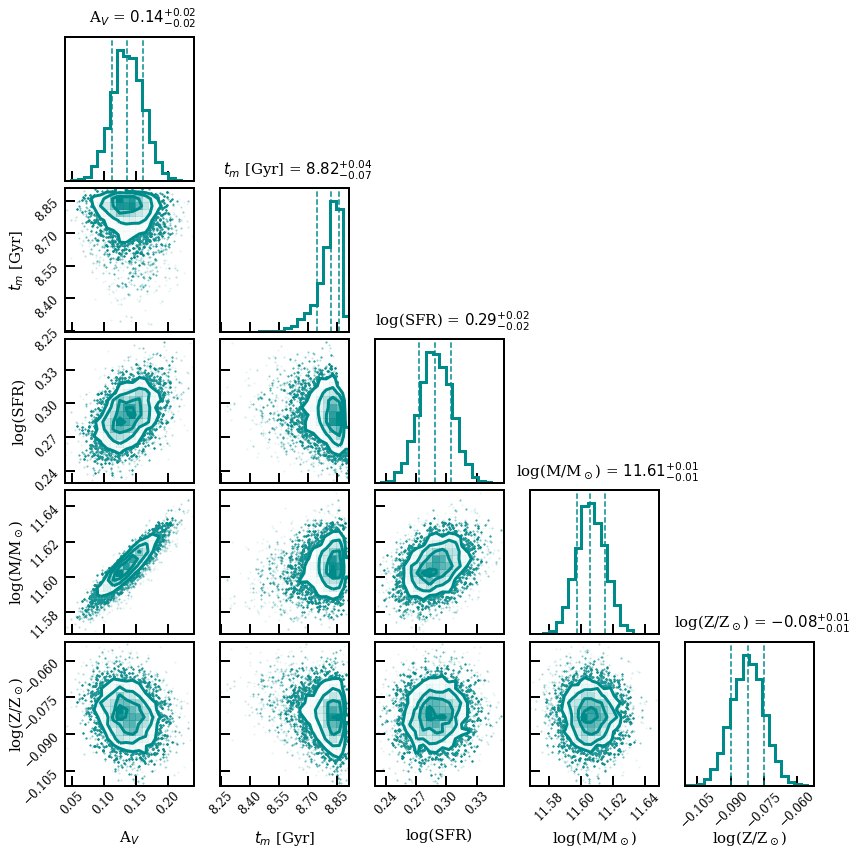

In [9]:
cornerfig = corner_plot(AV, mw_age, starFR, logM, met, redshift)

for ax in cornerfig.get_axes():
    ax.tick_params(axis='both', labelsize=12, length=10, width=2, direction='in')

plt.subplots_adjust(wspace=0.20, hspace=0.05)

In [10]:
# Make the SED
fin = makeSED(res, obs, mod, sps, 50)

In [11]:
# Is there an observed spectrum?
spec_run_bool = True

In [12]:
# Load in filter transmission curves

filt_wave = []
filt_trans = []
for filt in obs['filternames']:
    print(filt)
    lfilt = load_filters([filt])
    filt_wave.append(lfilt[0].wavelength.copy())
    filt_trans.append(lfilt[0].transmission.copy())
    
    
filt_wave = np.array(filt_wave, dtype=object)
filt_trans = np.array(filt_trans, dtype=object)

sdss_u0
sdss_g0
sdss_r0
sdss_i0
sdss_z0
twomass_J
twomass_H
twomass_Ks


In [13]:
# You'll need to change this based on what you want to label your filters
filt_labels = np.array(['u','g', 'r', 'i', 'z', 'J', 'H', 'K'])
# If you need to multiply a curve by some number for plotting purposes
# SDSS * 1, NIR (JHK)*1e4
filt_mult = np.array([1, 1, 1, 1, 1, 1e4, 1e4, 1e4])

# Choose some colors for your transmission curves
color_arr = np.array(['orchid','navy', 'cornflowerblue', 'forestgreen', 'limegreen','goldenrod', 'orange', 'palevioletred', 'red',
                      'firebrick','darkred','slategray', 'darkslategray','black'])

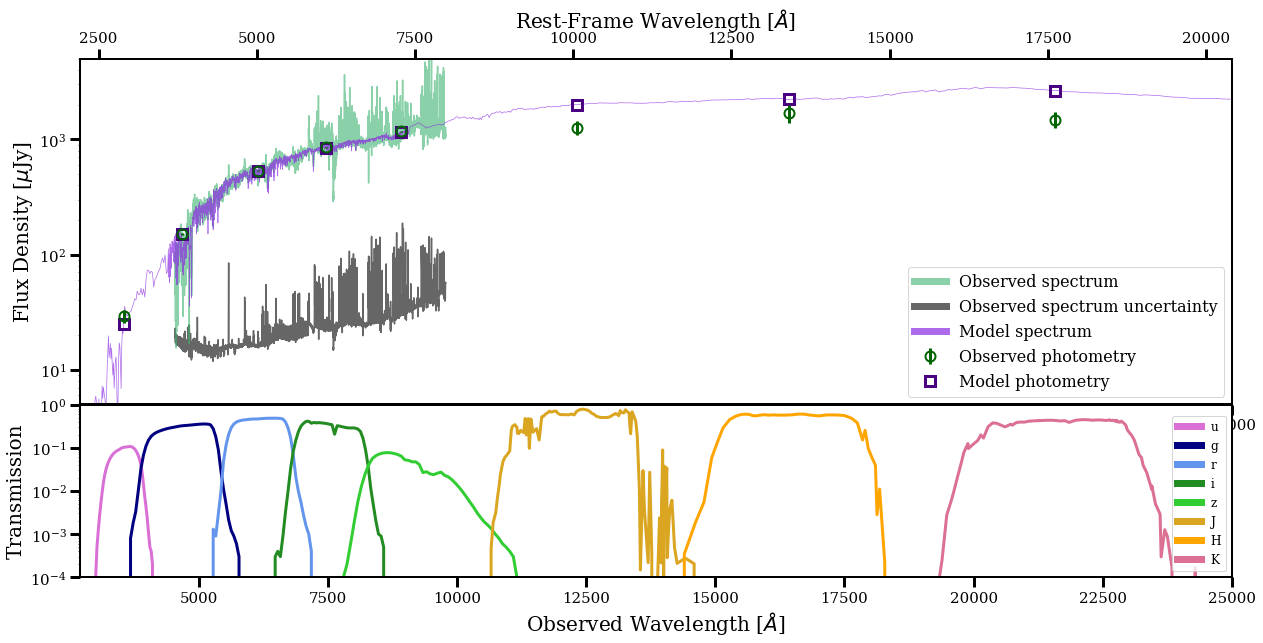

In [14]:
fig = plt.figure(figsize=(20,12))
    
# Set observed wavelength min and max
obs_wmin = 2.7e3
obs_wmax = 25e3
    
# Convert to rest-frame min and max for second axis
zred = mod.params.get('zred') # redshift
RF_wmin = obs_wmin/(1+zred)
RF_wmax = obs_wmax/(1+zred)

ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.4],
                    xlim=(obs_wmin, obs_wmax), ylim =(5e0, 5e3)) #, xticklabels=[])
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2], xlim = (obs_wmin, obs_wmax), ylim =(1e-4, 1e0))

# Adding in Rest-frame wavelength to top axis
ax3 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

ax3.tick_params(axis='x')
ax3.set_xlim((RF_wmin,RF_wmax))


# Observed photometry 
ax1.errorbar(fin['phot_wave'], fin['obs_phot'], yerr = fin['obs_phot_unc'], 
             label='Observed photometry', ecolor='darkgreen', 
             marker='o', markersize=10, ls='', lw=3, alpha=1.0, 
             markerfacecolor='none', markeredgecolor='darkgreen', markeredgewidth=2, zorder=4) 

if spec_run_bool == True:
    # Observed spectroscopy and error
    ax1.semilogy(fin['spec_wave'], fin['obs_spec'], color='mediumseagreen', alpha=0.6, 
                 zorder=1, label='Observed spectrum') # binned spec

    ax1.semilogy(fin['spec_wave'], fin['obs_spec_err'], color='k', alpha=0.6, 
                 zorder=0, label='Observed spectrum uncertainty')
     
    # Model photometry 
    ax1.errorbar(fin['phot_wave'], fin['model_phot'], label='Model photometry',
                 marker='s', markersize=10, alpha=1.0, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=3)

    # Model spectroscopy - just convering spec region
    ax1.semilogy(fin['full_spec_wave'], fin['model_spec'], label='Model spectrum',
                 lw=0.7, color='blueviolet', alpha=0.7, zorder=2)
    


else:
    # Model photometry 
    ax1.errorbar(fin['phot_wave'], fin['model_phot'], label='Model photometry',
                 marker='s', markersize=10, alpha=1.0, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=3)

    # Model spectroscopy - full wavelength range
    ax1.semilogy(fin['spec_wave'], fin['model_spec'], label='Model spectrum',
                 lw=0.7, color='blueviolet', alpha=0.7, zorder=2)
    
# Upper Limit
upper_limit = False
if upper_limit:
    up_l = np.array([f.wave_effective for f in load_filters(['sdss_g0'])])
    ax1.scatter(up_l, [10**(-0.4*25.2641)*3631e6], 
                color='darkgreen', marker='v', s=400)
    
    ulfilt = load_filters(['sdss_g0'])
    ul_wave = ulfilt[0].wavelength.copy()
    ul_trans = ulfilt[0].transmission.copy()
    
    ax2.semilogy(ul_wave, ul_trans, alpha=1.0, label='i', lw=3, color='limegreen')
    
    
from matplotlib.legend_handler import HandlerLine2D
def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(7)
    
# Axis 1 info
ax1.legend(loc='lower right', fontsize=16,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)


for i in np.arange(0, len(filt_wave), 1):
    ax2.semilogy(filt_wave[i], filt_trans[i]*filt_mult[i], alpha=1.0, label=filt_labels[i], lw=3, color=color_arr[i])

#ax2.ylabel('Transmission')
ax2.legend(loc='lower right', fontsize=12,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
ax2.set_ylabel(r'Transmission', fontsize=20)


ax2.set_xlabel(r'Observed Wavelength [$\AA$]',fontsize =20)
ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)

ax3.set_xlabel(r'Rest-Frame Wavelength [$\AA$]', fontsize=20)


import matplotlib.pyplot as plt

ax = plt.gca()

import matplotlib.axes

ax.tick_params(width=3)
ax1.tick_params(width=3, length=10, labelsize=15)
ax2.tick_params(width=3, length=10, labelsize=15)
ax3.tick_params(width=3, length=10, labelsize=15)


plt.show()